Step 1: Load Required Libraries

In [14]:
# Install required libraries
!pip install numpy pandas matplotlib tensorflow pyreadr

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam


Step 2: Load and Prepare the Dataset

In [15]:
import pyreadr

# Load the RDS file
result = pyreadr.read_r('/content/waterDataTraining.RDS')  # Update path if needed
data = result[None]  # Extract the dataframe

# Columns to use
columns = ['Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm', 'Fm_2']
data = data[columns]

# Display data information
print(data.head())
print(data.info())


    Tp    Cl    pH  Redox   Leit  Trueb   Cl_2      Fm   Fm_2
0  6.5  0.17  8.36  749.0  211.0  0.011  0.118  1677.0  695.0
1  6.5  0.17  8.36  749.0  211.0  0.011  0.118  1561.0  696.0
2  6.5  0.17  8.35  749.0  211.0  0.011  0.117  1581.0  696.0
3  6.5  0.17  8.35  749.0  211.0  0.011  0.118  1579.0  693.0
4  6.5  0.17  8.35  749.0  211.0  0.011  0.118  1567.0  689.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139566 entries, 0 to 139565
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Tp      138522 non-null  float64
 1   Cl      138521 non-null  float64
 2   pH      138522 non-null  float64
 3   Redox   138522 non-null  float64
 4   Leit    138522 non-null  float64
 5   Trueb   138522 non-null  float64
 6   Cl_2    138522 non-null  float64
 7   Fm      138522 non-null  float64
 8   Fm_2    138522 non-null  float64
dtypes: float64(9)
memory usage: 9.6 MB
None


2.2 Handle Missing Values

In [16]:
# Fill missing values with the column mean
data_cleaned = data.fillna(data.mean())

# Verify missing values are handled
print(data_cleaned.isna().sum())  # Should print all zeros


Tp       0
Cl       0
pH       0
Redox    0
Leit     0
Trueb    0
Cl_2     0
Fm       0
Fm_2     0
dtype: int64


2.3 Normalize the Data

In [18]:
# Normalize the data to range [0, 1]
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=data_cleaned.columns)

# Verify normalization
print(data_normalized.describe())


                  Tp             Cl             pH          Redox  \
count  139566.000000  139566.000000  139566.000000  139566.000000   
mean        0.722153       0.206852       0.884565       0.761175   
std         0.108179       0.012711       0.020510       0.021675   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.635593       0.200000       0.879214       0.757983   
50%         0.711864       0.212500       0.885291       0.763025   
75%         0.805085       0.212500       0.889343       0.766387   
max         1.000000       1.000000       1.000000       1.000000   

                Leit          Trueb           Cl_2             Fm  \
count  139566.000000  139566.000000  139566.000000  139566.000000   
mean        0.324336       0.077866       0.229651       0.391081   
std         0.011948       0.021540       0.015378       0.052865   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.323529       0.0629

In [3]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=columns)

# Check normalized data
print(data_normalized.head())


         Tp      Cl        pH     Redox      Leit     Trueb      Cl_2  \
0  0.550847  0.2125  0.883266  0.754622  0.326625  0.043307  0.255411   
1  0.550847  0.2125  0.883266  0.754622  0.326625  0.043307  0.255411   
2  0.550847  0.2125  0.881240  0.754622  0.326625  0.043307  0.253247   
3  0.550847  0.2125  0.881240  0.754622  0.326625  0.043307  0.255411   
4  0.550847  0.2125  0.881240  0.754622  0.326625  0.043307  0.255411   

         Fm      Fm_2  
0  0.427479  0.268133  
1  0.397910  0.268519  
2  0.403008  0.268519  
3  0.402498  0.267361  
4  0.399439  0.265818  


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:543: RuntimeWarning: invalid value encountered in multiply
  X *= self.scale_


Step 3: Create Time-Series Sequences

In [19]:
# Function to create time-series sequences
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps + 1):
        seq = data.iloc[i : i + timesteps].values
        sequences.append(seq)
    return np.array(sequences)

# Set time steps
timesteps = 30

# Create sequences
input_data = create_sequences(data_normalized, timesteps)
print(f"Input shape: {input_data.shape}")  # Example: (num_samples, timesteps, num_features)


Input shape: (139537, 30, 9)


Step 4: Split Data into Training and Validation Sets

In [20]:
# Split the data into training and validation sets
X_train, X_val = train_test_split(input_data, test_size=0.2, random_state=42)
print(f"Training shape: {X_train.shape}, Validation shape: {X_val.shape}")


Training shape: (111629, 30, 9), Validation shape: (27908, 30, 9)


Step 5: Build and Compile the LSTM Autoencoder

In [21]:
# Define the LSTM Autoencoder
model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, input_data.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(input_data.shape[2]))
])

# Compile the model with a low learning rate and gradient clipping
model.compile(optimizer=Adam(learning_rate=0.0001, clipvalue=1.0), loss='mse')
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 64)              │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 30, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 30, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 9)               │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,097 (254.29 KB)

 Trainable params: 65,097 (254.29 KB)

 Non-trainable params: 0 (0.00 B)

Step 6: Train the Model

In [22]:
# Train the model
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    shuffle=True
)


Epoch 1/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0529 - val_loss: 4.4632e-04
Epoch 2/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 3.9181e-04 - val_loss: 2.4751e-04
Epoch 3/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 2.4327e-04 - val_loss: 1.8704e-04
Epoch 4/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.9941e-04 - val_loss: 1.5488e-04
Epoch 5/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.6500e-04 - val_loss: 1.2567e-04
Epoch 6/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.4787e-04 - val_loss: 1.3147e-04
Epoch 7/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.2715e-04 - val_loss: 1.1402e-04
Epoch 8/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - loss: 1.0948e-04 - val_loss: 1.0552e-04
Epoch 9/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 1.0808e-04 - val_loss: 9.1838e-05
Epoch 10/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 1.0049e-04 - val_loss: 9.3722e-05
Epoch 11/50
1745/1745 ━

Step 7: Plot the Loss Curve

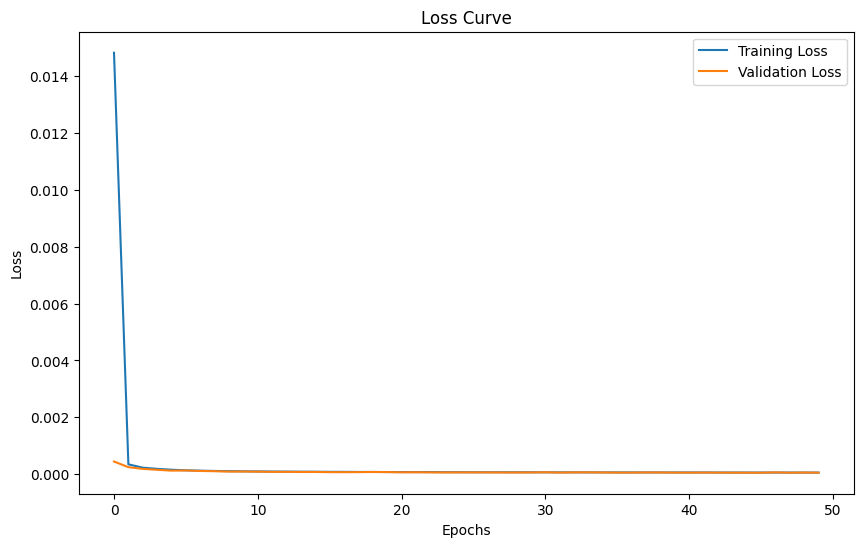

In [23]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Step 8: Evaluate Reconstruction Errors

In [24]:
# Predict on validation data
reconstructed = model.predict(X_val)

# Calculate reconstruction error
reconstruction_error = np.mean(np.power(X_val - reconstructed, 2), axis=(1, 2))
print(f"Reconstruction error shape: {reconstruction_error.shape}")


873/873 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Reconstruction error shape: (27908,)


Step 9: Define Anomaly Threshold

In [25]:
# Define threshold (95th percentile of reconstruction error)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly detection threshold: {threshold}")

# Identify anomalies
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")


Anomaly detection threshold: 8.251359841365316e-05
Number of anomalies detected: 1396


Step 10: Visualize Reconstruction Errors

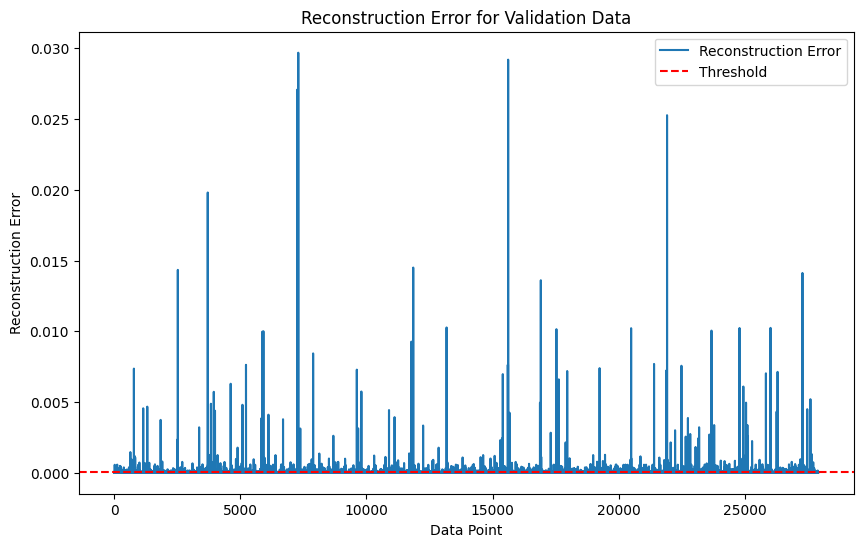

In [26]:
# Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title("Reconstruction Error for Validation Data")
plt.xlabel("Data Point")
plt.ylabel("Reconstruction Error")
plt.show()


Step 11: Examples of Well-Predicted and Poorly-Predicted Data

In [27]:
# Example of well-predicted data
well_predicted_index = np.argmin(reconstruction_error)
print(f"Well-predicted data point (index {well_predicted_index}):")
print(f"Original: {X_val[well_predicted_index]}")
print(f"Reconstructed: {reconstructed[well_predicted_index]}")

# Example of poorly-predicted data
poorly_predicted_index = np.argmax(reconstruction_error)
print(f"Poorly-predicted data point (index {poorly_predicted_index}):")
print(f"Original: {X_val[poorly_predicted_index]}")
print(f"Reconstructed: {reconstructed[poorly_predicted_index]}")


Well-predicted data point (index 188):
Original: [[0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.20685246 0.88456528 0.7611748  0.32433591 0.07786626
  0.22965124 0.39108052 0.35791976]
 [0.72215305 0.